In [203]:
import numpy as np
import pandas as pd


In [204]:
data = pd.read_csv("https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv")
data.index

RangeIndex(start=0, stop=9704, step=1)

In [205]:
df = data[['engine_displacement','horsepower','vehicle_weight','model_year','fuel_efficiency_mpg']]
df.head(5)

,engine_displacement,horsepower,vehicle_weight,model_year,fuel_efficiency_mpg
0,170,159.0,3413.433759,2003,13.231729
1,130,97.0,3149.664934,2007,13.688217
2,170,78.0,3079.038997,2018,14.246341
3,220,NaN,2542.392402,2009,16.912736
4,210,140.0,3460.870990,2009,12.488369


<Axes: xlabel='fuel_efficiency_mpg', ylabel='Count'>

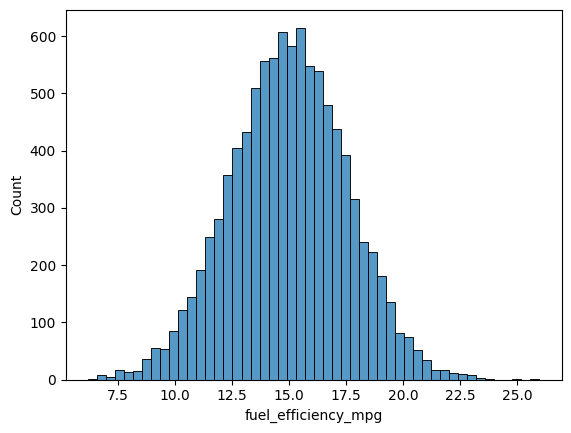

In [206]:
import seaborn as sns
sns.histplot(df['fuel_efficiency_mpg'], bins=50)

In [207]:
df.isnull().sum()

engine_displacement      0
horsepower             708
vehicle_weight           0
model_year               0
fuel_efficiency_mpg      0
dtype: int64

In [208]:
df.horsepower.median()

np.float64(149.0)

In [209]:
n =len(df)
n_train = int(n * 0.6)
n_val = int(n * 0.2)
n_test = n-n_train-n_val 


idx =np.arange(n)
np.random.seed(42)
np.random.shuffle(idx)

In [210]:
df_train = df.iloc[idx[:n_train]]
df_val = df.iloc[idx[n_train : n_val + n_train]]
df_test = df.iloc[idx[n_train + n_val: ]]

In [211]:
len(df_train),len(df_val),len(df_test)

(5822, 1940, 1942)

In [212]:
df_train.reset_index(drop=True)
df_val.reset_index(drop=True)
df_test.reset_index(drop=True)


y_train = df_train.fuel_efficiency_mpg
y_val = df_val.fuel_efficiency_mpg
y_test = df_test.fuel_efficiency_mpg

del df_train['fuel_efficiency_mpg']
del df_val['fuel_efficiency_mpg']
del df_test['fuel_efficiency_mpg']

In [213]:
def train_model (x, y):
    ones = np.ones(x.shape[0])
    X = np.column_stack([ones, x])
    XT = X.T
    XTX = XT.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    wfull = XTX_inv.dot(XT).dot(y)

    return wfull[0], wfull[1:]
    

In [214]:
def rmse(y_old, y_pred):
    error = y_old - y_pred
    sq = error **2
    mse = sq.mean()
   

    return np.sqrt(mse)

In [215]:
features = ['engine_displacement','horsepower','vehicle_weight']

### filling nan with 0

In [216]:
def prepare_x0(df):
    df = df.copy()
    #df['age'] = 2023 - df.model_year
    #df = df[features]
    df = df.fillna(0)
    x = df.values
    return x

In [217]:
x_train = prepare_x0(df_train)
w0,w = train_model (x_train, y_train)

y_pred = w0 + x_train.dot(w)
rmse(y_train,y_pred)

np.float64(0.5203457641474558)

In [218]:
x_train = prepare_x0(df_train)
w0,w = train_model (x_train, y_train)

x_val = prepare_x0(df_val)
y_pred_val = w0 + x_val.dot(w)
rmse(y_val,y_pred_val).round(2)

np.float64(0.52)

### filling nan with mean

In [219]:
df.horsepower.mean()

np.float64(149.65729212983547)

In [220]:
def prepare_xmean(df):
    df = df.copy()
    #df['age'] = 2023 - df.model_year
    #df = df[features]
    df = df.fillna(df.horsepower.mean())
    x = df.values
    return x

In [221]:
x_train = prepare_xmean(df_train)
w0,w = train_model (x_train, y_train)

y_pred = w0 + x_train.dot(w)
rmse(y_train,y_pred)

np.float64(0.4625139498401926)

In [222]:
x_train = prepare_xmean(df_train)
w0,w = train_model (x_train, y_train)

x_val = prepare_xmean(df_val)
y_pred_val = w0 + x_val.dot(w)
rmse(y_val,y_pred_val).round(2)

np.float64(0.46)

### applying regularization and tuning of r

In [223]:
def train_model_reg(x, y,r=r):
    ones = np.ones(x.shape[0])
    X = np.column_stack([ones, x])
    XT = X.T
    XTX = XT.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])
    XTX_inv = np.linalg.inv(XTX)
    wfull = XTX_inv.dot(XT).dot(y)

    return wfull[0], wfull[1:]

In [228]:
for r in [0, 0.01, 0.1, 1, 5, 10, 100]:
   
    x_train = prepare_x0(df_train)
    w0,w = train_model (x_train, y_train)
    
    x_val = prepare_x0(df_val)
    y_pred_val = w0 + x_val.dot(w)
    score= rmse(y_val,y_pred_val).round(2)
    print(r,w0,score)
    

0 27.505863975451373 0.5131330922635593
0.01 27.505863975451373 0.5131330922635593
0.1 27.505863975451373 0.5131330922635593
1 27.505863975451373 0.5131330922635593
5 27.505863975451373 0.5131330922635593
10 27.505863975451373 0.5131330922635593
100 27.505863975451373 0.5131330922635593


### Checking the influence of the seed on the model

In [225]:
df_copy = df.copy()
n=len(df_copy)
n_train = int(n * 0.6)
n_val = int ( n * 0.2)
n_test = int ( n - n_train - n_val)

score=[]
for seed in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:
    idx =np.arange(n)
    np.random.seed(seed)
    np.random.shuffle(idx)
    
    df_train = df.iloc[idx[:n_train]]
    df_val = df.iloc[idx[n_train : n_val + n_train]]
    df_test = df.iloc[idx[n_train + n_val: ]]


    df_train.reset_index(drop=True)
    df_val.reset_index(drop=True)
    df_test.reset_index(drop=True)
    
    
    y_train = df_train.fuel_efficiency_mpg
    y_val = df_val.fuel_efficiency_mpg
    y_test = df_test.fuel_efficiency_mpg
    
    del df_train['fuel_efficiency_mpg']
    del df_val['fuel_efficiency_mpg']
    del df_test['fuel_efficiency_mpg']

    x_train = prepare_x0(df_train)
    w0,w = train_model(x_train, y_train)
    
    x_val = prepare_x0(df_val)
    y_pred_val = w0 + x_val.dot(w)
    score_val = rmse(y_val,y_pred_val)
    score = score + [score_val.round(2)]
    print(r, w0, score_val.round(2))
    
    print()


100 27.32932514630192 0.52

100 28.940064355319876 0.52

100 25.857415150834832 0.52

100 28.07301575626919 0.52

100 25.959601822989377 0.51

100 25.834054960277204 0.53

100 25.901665013380573 0.53

100 28.409009906210905 0.51

100 26.45827739830252 0.51

100 27.505863975451373 0.51



In [226]:
score = np.array(score)
round(np.std(score),3)

np.float64(0.007)

### using the model with seed 9

In [229]:
df_copy = df.copy()
n=len(df_copy)
n_train = int(n * 0.6)
n_val = int ( n * 0.2)
n_test = int ( n - n_train - n_val)


idx =np.arange(n)
np.random.seed(9)
np.random.shuffle(idx)

df_train = df.iloc[idx[:n_train]]
df_val = df.iloc[idx[n_train : n_val + n_train]]
df_test = df.iloc[idx[n_train + n_val: ]]


df_train.reset_index(drop=True)
df_val.reset_index(drop=True)
df_test.reset_index(drop=True)


y_train = df_train.fuel_efficiency_mpg
y_val = df_val.fuel_efficiency_mpg
y_test = df_test.fuel_efficiency_mpg

del df_train['fuel_efficiency_mpg']
del df_val['fuel_efficiency_mpg']
del df_test['fuel_efficiency_mpg']

df_full_train = pd.concat([df_train,df_val])
y_full_train = np.concatenate([y_train,y_val])

r=0.001
x_train = prepare_x0(df_full_train)
w0,w = train_model_reg(x_train, y_full_train,r)

x_val = prepare_x0(df_val)
y_pred_val = w0 + x_val.dot(w)
score_val = rmse(y_val,y_pred_val)
print(r, w0, score_val)

print()


0.001 26.95024183040363 0.512809093700119

